<a href="https://colab.research.google.com/github/hpink97/ML_notebooks/blob/main/04_LSTM_stock_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create a Long-Short Term Memory Neural Network to predict future stock prices

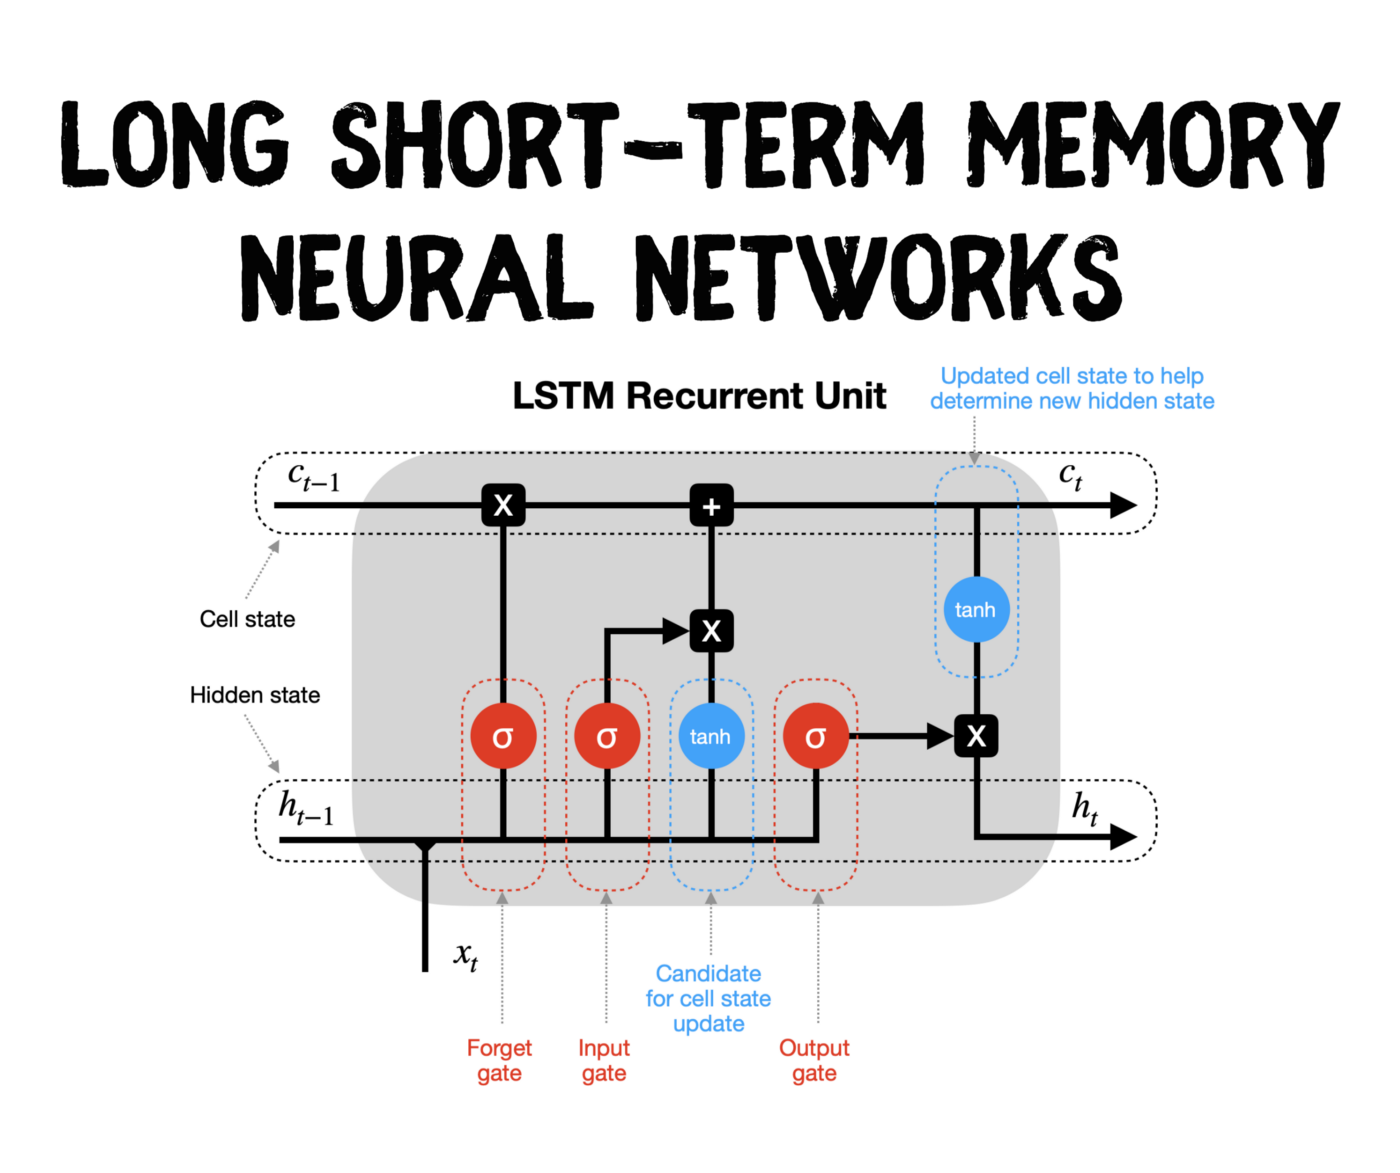

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb



## **Import Data**

Look at S&P500 stock price data from 1990 to 2022, split into 2 files, 1945-2020 and 2012-2022

In [2]:
data_URL = 'https://raw.githubusercontent.com/hpink97/ML_notebooks/main/data/'

data1 = pd.read_csv(f"{data_URL}sp500_1927_2020.csv")
data1.Date = pd.to_datetime(data1.Date)
data1 = data1[data1.Date >='1995-01-01']

data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
16815,1995-01-03,459.209991,459.269989,457.200012,459.109985,459.109985,262450000
16816,1995-01-04,459.130005,460.720001,457.559998,460.709991,460.709991,319510000
16817,1995-01-05,460.730011,461.299988,459.750000,460.339996,460.339996,309050000
16818,1995-01-06,460.380005,462.489990,459.470001,460.679993,460.679993,308070000
16819,1995-01-09,460.670013,461.769989,459.739990,460.829987,460.829987,278790000


In [3]:
data2 = pd.read_csv(f"{data_URL}sp500_2012_2022.csv")
data2.Date = pd.to_datetime(data2.Date)

data2 = data2[data2.Date > data1.Date.max()]
data2 = data2.rename(columns={'Close/Last': 'Close'})
data2 = data2.sort_values('Date')

data2.tail()

,Date,Close,Volume,Open,High,Low
4,2022-12-21,3878.44,--,3839.49,3889.82,3839.49
3,2022-12-22,3822.39,--,3853.26,3853.26,3764.49
2,2022-12-23,3844.82,--,3815.11,3845.80,3797.01
1,2022-12-27,3829.25,--,3843.34,3846.65,3813.22
0,2022-12-28,3783.22,--,3829.56,3848.32,3780.78


Combine the two dataframes together and create a 10-day rolling mean

In [4]:

data_array = [data1[['Date','Close']], data2[['Date','Close']]]

df = pd.concat(data_array, ignore_index=True, sort=False)
##fill in missing days
df = df.set_index('Date').resample('1D').mean().bfill()
df['rolling_mean'] = df.rolling(window=5).mean()
df['Date'] = df.index
df = df.dropna()




## Exploratory Data Analysis (EDA)

* Plot stock prices since 1945
* Calculate Annual percentage change

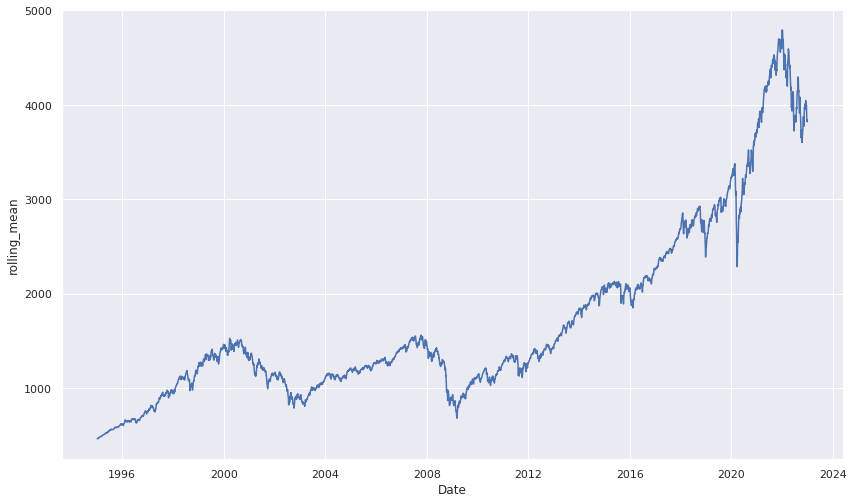

In [5]:
sns.set(rc={'figure.figsize':(14.0,8.27)})
sns.lineplot(data=df, x="Date", y="rolling_mean")

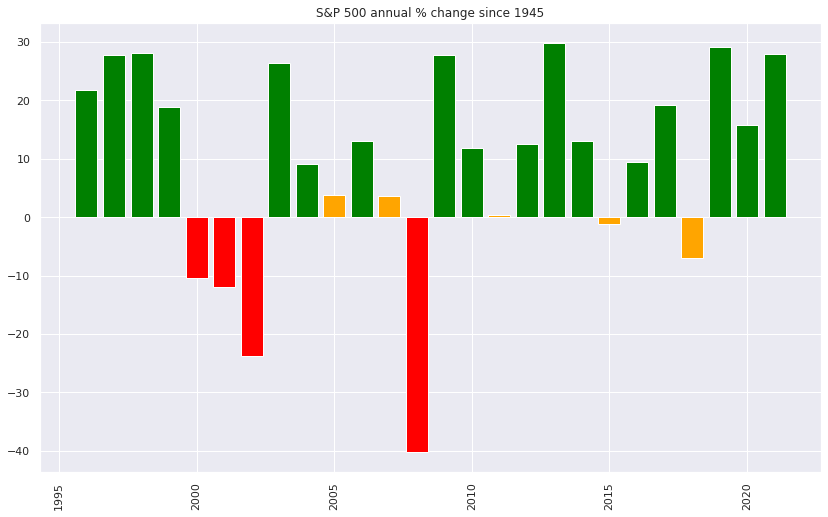

In [6]:
###calculate percentage change by year
pcnt_change = df.copy()
pcnt_change['year'] = df.Date.dt.year
pcnt_change['month'] = df.Date.dt.month
pcnt_change['day'] = df.Date.dt.day
pcnt_change = pcnt_change.loc[(pcnt_change.month ==12) &( pcnt_change.day ==31),['year','rolling_mean']]
pcnt_change['yr_pcnt_change'] = 100*pcnt_change['rolling_mean'].pct_change()
pcnt_change = pcnt_change.dropna()

x=pcnt_change.year
y=pcnt_change.yr_pcnt_change

profit_color = [{p< -10: 'red', -10<=p<=10: 'orange', p>8: 'green'}[True] for p in y]

plt.bar(x, y, color=profit_color)
plt.title('S&P 500 annual % change since 1945')
plt.xticks(rotation=90)
plt.show()

## Peform pre-processing of data for training

In [7]:
### convert to numpy array 7day rolling average 
df = df.dropna()
vals = df['rolling_mean'].values.reshape(-1, 1)
vals = vals.astype('float32') #COnvert values to float

vals[[0,69,5000,6500]]

array([[ 460.33398],
       [ 493.15   ],
       [1215.77   ],
       [1424.664  ]], dtype=float32)

In [8]:
##scale all stock prices to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
vals = scaler.fit_transform(vals)
vals[[0,69,5000,6500]]

array([[0.        ],
       [0.0075783 ],
       [0.17445505],
       [0.22269553]], dtype=float32)

In [9]:
##split into train-test split
train_size = int(len(vals) * 0.7) 
validation_size = int(len(vals) * 0.85)
test_size = len(vals) - validation_size
train,validation, test = vals[0:train_size,:],vals[train_size:validation_size,:] ,vals[validation_size:len(vals),:]

print(f"S&P500 data has been into train ({len(train)} datapoints), validation ({len(validation)} datapoints) and test ({len(test)} datapoints). ")
print(f"Training data is from {df.Date[0]:%d/%m/%Y} until {df.Date[train_size-1]:%d/%m/%Y}")
print(f"Validation data is from  {df.Date[train_size]:%d/%m/%Y} until {df.Date[validation_size-1]:%d/%m/%Y}")
print(f"Testing data is from  {df.Date[validation_size]:%d/%m/%Y} until {df.Date[len(vals)-1]:%d/%m/%Y}")

##Test samples are after {df.Date[train_size]}"

S&P500 data has been into train (7152 datapoints), validation (1533 datapoints) and test (1533 datapoints). 
Training data is from 07/01/1995 until 06/08/2014
Validation data is from  07/08/2014 until 17/10/2018
Testing data is from  18/10/2018 until 28/12/2022


In [10]:
len(test)+len(train)+len(validation) == len(vals)

True

## Define a function to convert 

In [11]:
def to_sequences(dataset, n_past, n_future):
    x = []
    y = []

    for i in range(n_past, len(dataset) - n_future +1):
        #print(i)
        x.append(dataset[i - n_past:i,0])
        y.append(dataset[i + n_future - 1:i + n_future, 0])
        
    return np.array(x),np.array(y)



In [12]:
n_past = 26*5 ##approx 6 months of previous data to train on
n_future = 30 ## predict 6 weeks into the future

trainX, trainY = to_sequences(train, n_past,n_future)
validX, validY = to_sequences(validation, n_past,n_future) 
testX, testY = to_sequences(test, n_past,n_future)

In [13]:
##reshape data for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, n_past))
validX = np.reshape(validX, (validX.shape[0], 1, n_past))
testX = np.reshape(testX, (testX.shape[0], 1, n_past))

print(f"S&P500 data has been into train ({len(trainX)} datapoints), validation ({len(validX)} datapoints) and test ({len(testX)} datapoints). ")


S&P500 data has been into train (6993 datapoints), validation (1374 datapoints) and test (1374 datapoints). 


In [14]:
trainX.shape

(6993, 1, 130)

## Build the model

We're going to build a relatively LSTM recurrent neural network with dropout regularisation (hopefully avoid too much overfitting)


In [15]:
#print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(units = 36, input_shape = (None, n_past)))
model.add(Dropout(0.07))
model.add(Dense(8))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse',metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                24048     
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 8)                 296       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 24,353
Trainable params: 24,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
es = EarlyStopping(monitor='val_loss', 
                   min_delta=1e-5,
                   patience=30,
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True)

###fit to model 
history = model.fit(trainX, trainY, validation_data=(validX, validY),
          verbose=2, epochs=200,batch_size=512, callbacks=[es])

Epoch 1/200
14/14 - 3s - loss: 0.0047 - mae: 0.0527 - val_loss: 0.0136 - val_mae: 0.1133 - 3s/epoch - 238ms/step
Epoch 2/200
14/14 - 0s - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0025 - val_mae: 0.0455 - 81ms/epoch - 6ms/step
Epoch 3/200
14/14 - 0s - loss: 9.1057e-04 - mae: 0.0223 - val_loss: 6.1945e-04 - val_mae: 0.0199 - 76ms/epoch - 5ms/step
Epoch 4/200
14/14 - 0s - loss: 6.9371e-04 - mae: 0.0192 - val_loss: 8.0525e-04 - val_mae: 0.0237 - 91ms/epoch - 6ms/step
Epoch 5/200
14/14 - 0s - loss: 6.6327e-04 - mae: 0.0187 - val_loss: 7.3155e-04 - val_mae: 0.0226 - 106ms/epoch - 8ms/step
Epoch 6/200
14/14 - 0s - loss: 5.9164e-04 - mae: 0.0179 - val_loss: 5.3058e-04 - val_mae: 0.0188 - 80ms/epoch - 6ms/step
Epoch 7/200
14/14 - 0s - loss: 5.3022e-04 - mae: 0.0171 - val_loss: 5.0517e-04 - val_mae: 0.0185 - 81ms/epoch - 6ms/step
Epoch 8/200
14/14 - 0s - loss: 4.9036e-04 - mae: 0.0165 - val_loss: 5.0350e-04 - val_mae: 0.0187 - 90ms/epoch - 6ms/step
Epoch 9/200
14/14 - 0s - loss: 4.6723e-04 - mae

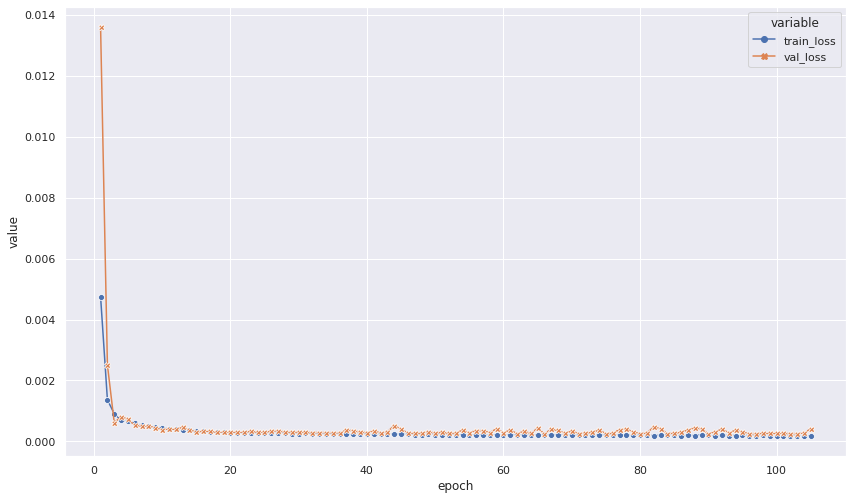

In [17]:
df = pd.DataFrame({'epoch':range(1, len(history.history['loss'])+1),
              'train_loss':history.history['loss'],
              'val_loss':history.history['val_loss']})

df_pivot = pd.melt(df, id_vars=['epoch'], value_vars=['train_loss','val_loss'])

sns.lineplot(data=df_pivot, x="epoch", y="value", hue="variable",style="variable",
    markers=True, dashes=False)

In [18]:
###use model to predict values for the validation set and testing set
## use our original scaler to reverse_transform to return to original values (USD)
validationPredict =  scaler.inverse_transform(model.predict(validX).reshape(-1,1))
testPredict =  scaler.inverse_transform(model.predict(testX).reshape(-1,1))

43/43 [==============================] - 0s 4ms/step


In [19]:
## again inverse_transform to get real Y-values back to USD
validY = scaler.inverse_transform(validY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

### As a best guess, use current S&P500 price, as a predictor of the price in six weeks...

-If we can beat this with our model, shows our prediction is better than just saying S&P500 price will be the same in 2 weeks

In [20]:
def get_last_X_from_series(sequence):
  x1 =  [sequence[i,0,n_past-1] for i in np.arange(len(sequence))]
  x2 = np.array(x1)
  x3 = np.reshape(x2,(-1,1))
  x4 = scaler.inverse_transform(x3)

  return x4



validation_lastX_equals_Y =  get_last_X_from_series(validX)
test_lastX_equals_Y = get_last_X_from_series(testX)


## Asses predictions



In [21]:
def assess_predictions(y_true, y_pred, prefix):
  ##calculate RMSE
  error = y_true-y_pred
  squared_error = error **2
  mean_squared_error = np.mean(squared_error)
  root_mean_squared_error = np.sqrt(mean_squared_error)

  ##calculate MAPE
  abs_error = np.absolute(error)
  abs_error_percentage = 100*(abs_error/y_true)
  median_abs_error_perc = np.median(abs_error_percentage)
  return f"{prefix} RMSE = ${root_mean_squared_error:.2f} and MAPE = {median_abs_error_perc:.2f}%"


Using the Median Absolute Percentage Error (MAPE), our LSTM is (marginally) more accurate than our "lastX_equals_Y" model - presuming stock price will be identical to that of 6 weeks ago

In [22]:
print(assess_predictions(validY, validation_lastX_equals_Y, 'validation_lastX_equals_Y'))
print(assess_predictions(validY, validationPredict, 'LSTM validation'))
print(assess_predictions(testY, test_lastX_equals_Y, 'test_lastX_equals_Y'))
print(assess_predictions(testY, testPredict, 'LSTM test'))


validation_lastX_equals_Y RMSE = $64.83 and MAPE = 1.75%
LSTM validation RMSE = $69.39 and MAPE = 1.64%
test_lastX_equals_Y RMSE = $202.30 and MAPE = 3.36%
LSTM test RMSE = $224.86 and MAPE = 2.82%
